# 어제 오른 내 주식, 과연 내일은?

- 목표
    - 주식 시세 데이터를 수집하고 전처리한다.
    - ARIMA 모델을 사용하여 주식 시세를 예측한다.
    - 모델의 성능을 평가하고 필요한 경우 모델을 튜닝한다.
    - 최종적으로 삼성전자의 주식 시세를 예측한다.

- 데이터셋  
[Yahoo Finance](https://finance.yahoo.com/?guccounter=1&guce_referrer=aHR0cHM6Ly9sbXMuYWlmZmVsLmlvLw&guce_referrer_sig=AQAAAGCeRzZPhDw1yjEwIpDTZWZMZhhNl76gtTBJ2NdfHUFBY4HMVR6z82o_gvXKjpnth0t8FqcgNWdKBsw0-aNbeeHUJ-56X7KBXh1y086RR6yrTAWoPoAR_c47m5-F0NaxL_GFIc4dUcHBpIF37DkPLiKaligEpW-zOE8a6Lpq37Y2)
에서 오늘 사용할 데이터셋을 다운로드할 수 있다.

## 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
    - 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있다.
- 종가(Close)만 사용
    - 종가: 하루의 장이 마감하였을 때의 가격
- 주식 시장은 정해진 시간 동안만 거래가 가능하다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Time Series 생성

In [3]:
df = pd.read_csv('005930.KS.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [4]:
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 각종 전처리 수행

### 결측치 처리

In [5]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### 로그 변환

In [6]:
ts_log = np.log(ts)
ts_log

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

## 시계열 안정성 분석

### Rolling Statistics
- 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
    - `현재 타임 스텝` 부터 `window에 주어진 타임 스텝 이전` 사이
    - 구간의 평균(rolling mean, `이동평균`)과
    - 구간의 표준편차(rolling std, `이동표준편차`)를  
    원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있을 것이다.

아래 코드에서 `window`는 다음 정의에서 특정 개수(d)에 해당한다. 
- **이동평균(Moving Average. 혹은 Rolling Mean)**
    - 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 평균
    - $E(X_t + X_{t+1} + X_{t+2} + ... + X_{t+d-1})$

- **이동표준편차(Rolling std)**
    - 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 표준편차
        - 표준편차: 분산에 제곱근을 씌운 값 $\sigma (X) = \sqrt{V AR(X)}$  
    - $\sigma(X_t + X_{t+1} + X_{t+2} + ... + X_{t+d-1})$

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#### 정성적 그래프 분석

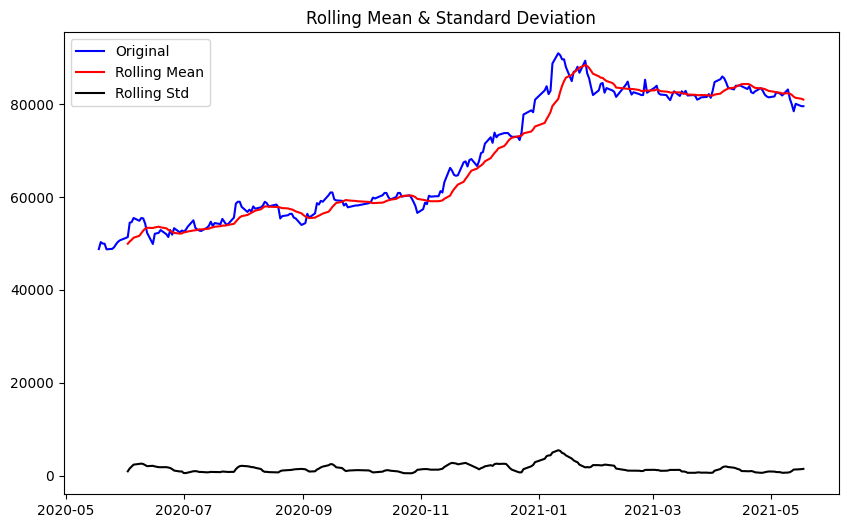

In [8]:
plt.figure(figsize=(10, 6))
plot_rolling_statistics(ts, window=12)

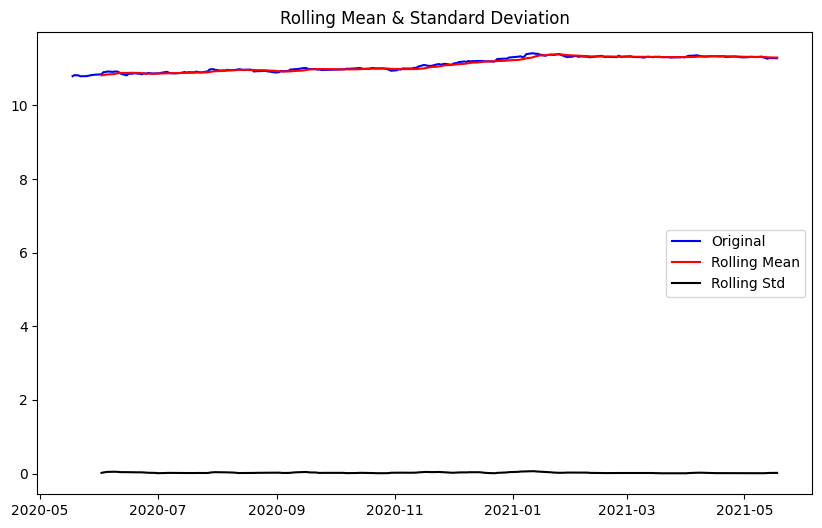

In [9]:
plt.figure(figsize=(10, 6))
plot_rolling_statistics(ts_log, window=12)

### **Augmented Dickey-Fuller Test(ADF Test)**
시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법
- `주어진 시계열 데이터가 안정적이지 않다`라는 `귀무가설(Null Hypothesis)`를 세운 후,  
통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에`이 시계열 데이터가 안정적이다`라는    
`대립가설(Alternative Hypothesis)`을 채택

[귀무가설, 대립가설](http://www.ktword.co.kr/test/view/view.php?m_temp1=6154&id=603)

[ADF Test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)

[유의확률(p-value)](https://ko.wikipedia.org/wiki/%EC%9C%A0%EC%9D%98_%ED%99%95%EB%A5%A0)

- **statsmodels 패키지와 adfuller 메서드**
    - R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지
    - `statsmodels` 패키지에서 제공하는 `adfuller` 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### 정량적 Augmented Dicky-Fuller Test

In [11]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- 해석
    - Test Statistic (테스트 통계량): 테스트 통계량 값이 Critical Value 값보다 작아야 한다. 
        - Test Statistic : -1.383525, Critical Value (1%) : -3.456888
            - Critical Value 보다 크기 때문에 우리는 데이터가 안정적이지 않다는 귀무 가설을 기각할 수 없다.
            - 따라서 이 시계열 데이터는 안정적이지 않을 가능성이 있다.
    - p-value (p-값): p-value는 귀무 가설이 참일 확률
        - p-value가 0.05보다 작으면 귀무 가설을 기각한다.
        - p-value : 0.590149
            - 0.05보다 크므로 귀무 가설을 기각할 수 없다
            - 따라서 이 데이터는 안정적이지 않을 가능성이 높다.
    - #Lags Used (사용된 지연 수): ADF 테스트에서 사용된 시차의 수
        - #Lags Used : 0.000000
    - Number of Observations Used (사용된 관측치 수): 테스트에 사용된 관측치의 수
        -  Number of Observations Used : 249.000000
    -  Critical Values (임계 값): 테스트 통계량 값이 임계 값보다 작아야 안정적인 시계열이라고 간주된다.
        - 1%, 5%, 10% 수준에서의 임계 값이 제공된다.
        - 여기서 모든 임계 값은 테스트 통계량보다 크다.

결과적으로, 테스트 통계량이 Critical Value보다 크기 때문에 데이터가 안정적이지 않을 가능성이 있으며, p-value가 0.05보다 크므로 귀무 가설을 기각할 충분한 증거가 없다.  
따라서 이 시계열 데이터는 안정적이지 않을 가능성이 높다.

### 시계열 분해(Time Series Decomposition)

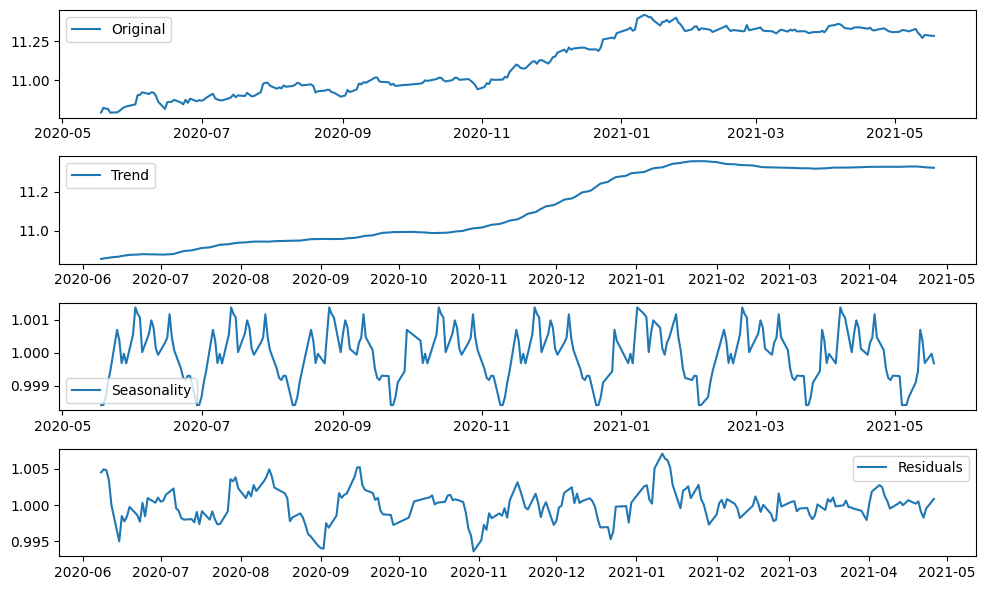

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Resudual 안정성 확인

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


- 해석
    - Test Statistic (테스트 통계량): -6.187586e+00
        - Critical Value 값보다 작기 때문에 시계열 데이터가 안정적이라는 증거가 된다.
    - p-value (p-값): 6.234854e-08
        - 매우 작기 때문에 귀무 가설을 기각하며, 시계열 데이터는 안정적이라고 할 수 있다.
        
따라서, 테스트 통계량이 Critical Value보다 작고, 매우 작은 p-value 값이 관찰되었으므로, 이 시계열 데이터는 안정적인 것으로 간주된다.

## 학습, 데이터 데이터셋 생성

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

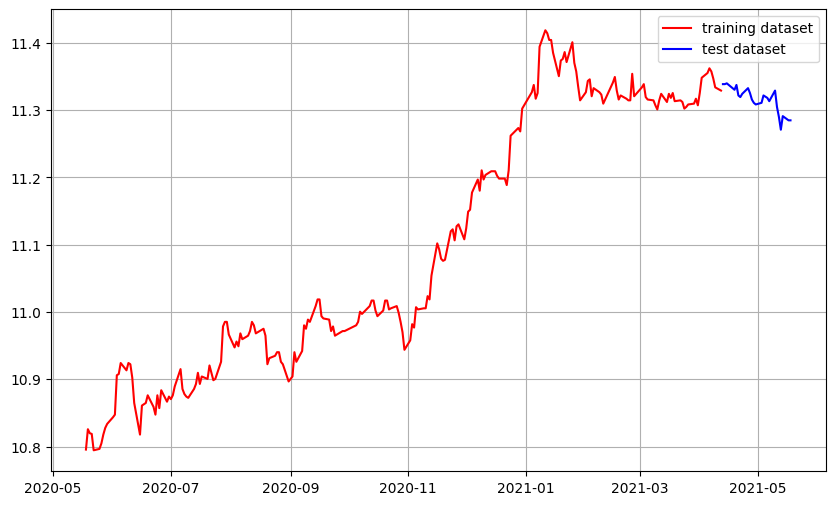

In [15]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

- train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택

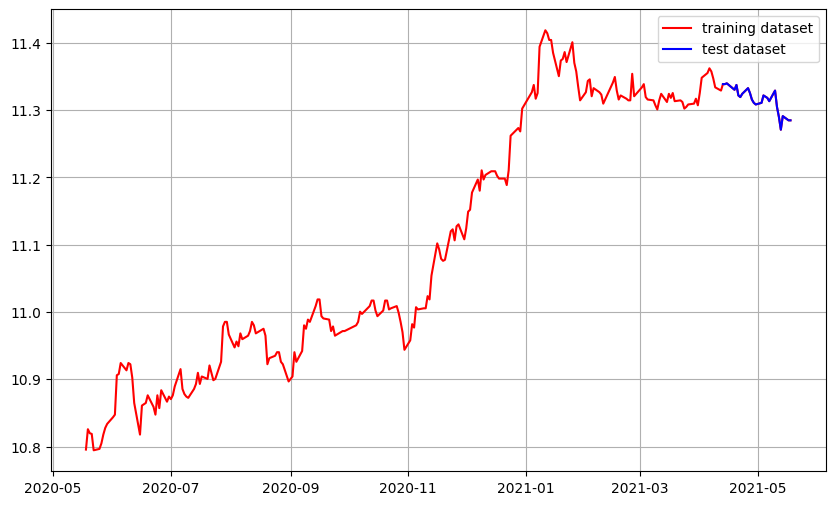

In [16]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기

### ACF, PACF 그려보기
- ACF 그래프
    - 그래프가 천천히 감소하는 경우 MA 모델의 순차적인 항목이 필요할 수 있다. 
    - 그래프가 시차 1에서 갑자기 감소하는 경우 q의 추정치를 결정할 수 있다.

- PACF 그래프
    - 그래프가 시차 1에서 갑자기 감소하는 경우 AR 모델의 순차적인 항목이 필요할 수 있다. 
    - 그래프가 천천히 감소하는 경우 p의 추정치를 결정할 수 있다.

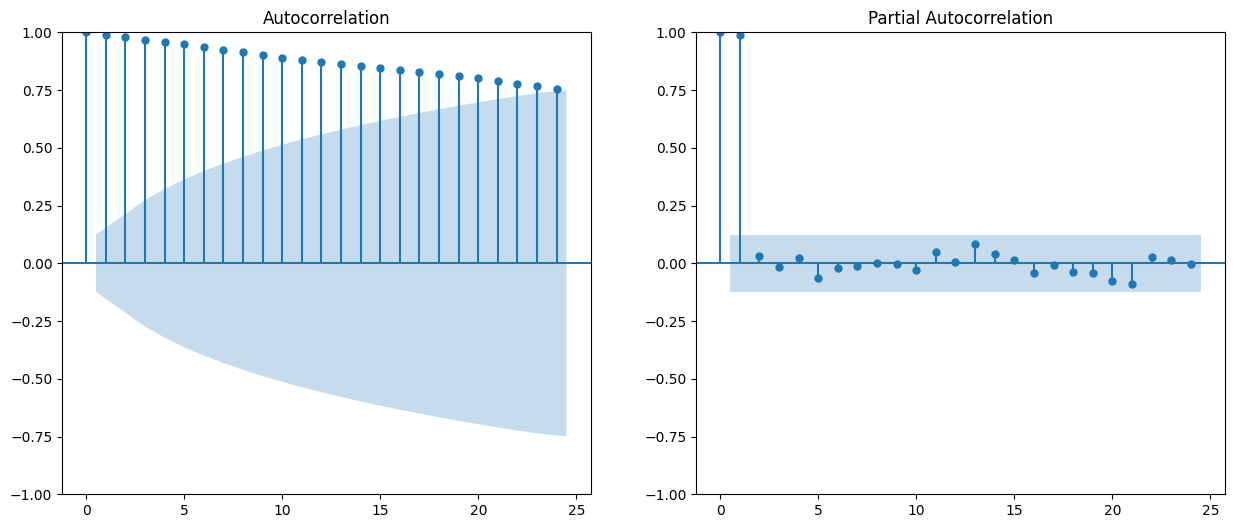

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(ts_log, ax=ax[0])   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, ax=ax[1])  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 차분 안정성 확인 -> d 구하기

#### 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


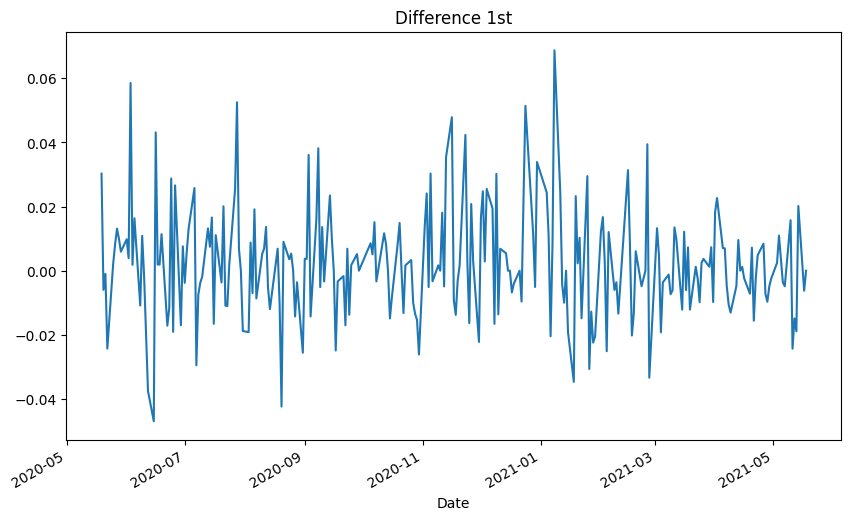

In [19]:
plt.figure(figsize=(10, 6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#### 2차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


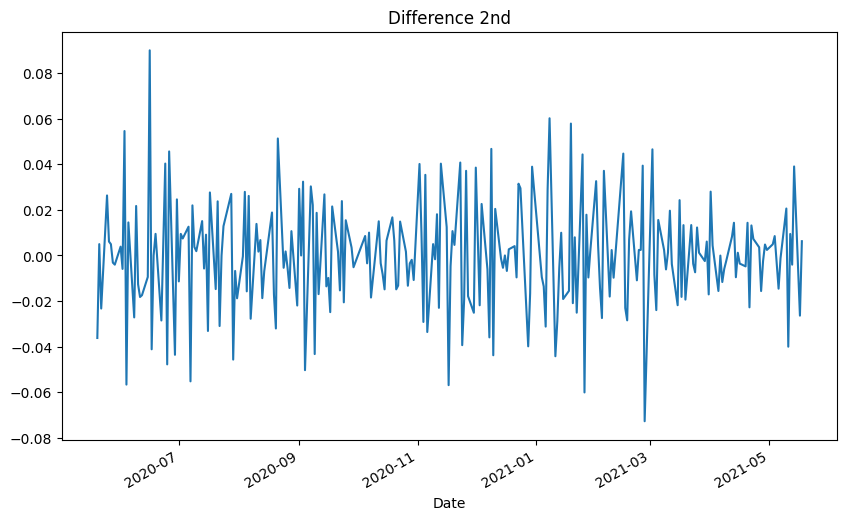

In [20]:
plt.figure(figsize=(10, 6))
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<Axes: title={'center': 'Difference 2nd'}, xlabel='Date'>

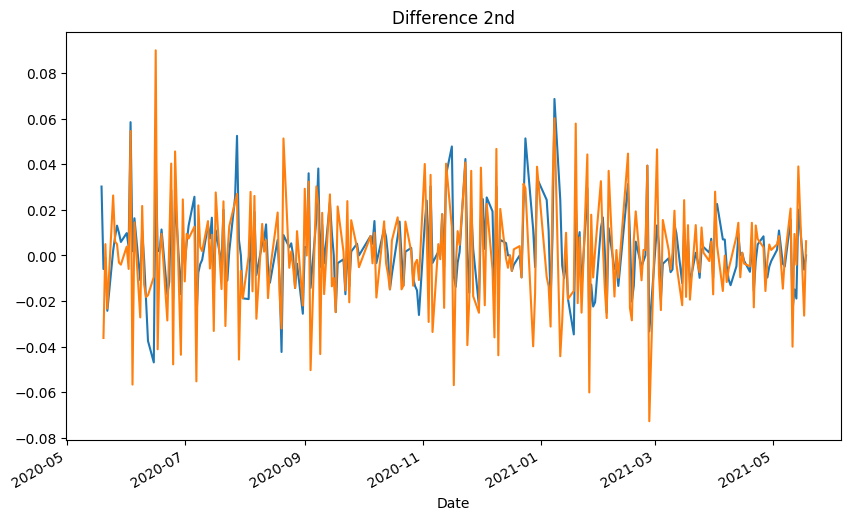

In [21]:
plt.figure(figsize=(10, 6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

## ARIMA 모델 훈련과 테스트

- ARIMA(p, d, q)
    - 자기회귀누적이동평균(Autoregressive Integrated Moving Average) 모델
        - 모델은 시계열 데이터를 예측하기 위해 사용
    - 매개변수
        - p: 자기회귀(AR, Autoregression) 항의 개수
            - 자기회귀: 현재 값이 이전 값의 선형 조합으로 표현될 수 있는 모델을 의미
            - p 값은 시계열 데이터의 이전 값을 사용하여 현재 값을 예측하는 데 사용되는 시차(lag)의 개수
        
        - d: 차분(Differencing) 차수
            - 차분: 시계열 데이터의 정상성을 확보하기 위해 이전 값과의 차이를 계산하는 것
            - d 값이 0인 경우에는 차분이 없음을 의미하며, 시계열 데이터가 정상 시계열이거나 이미 차분된 데이터인 경우에 해당

        - q: 이동평균(MA, Moving Average) 항의 개수
            - 이동평균: 이전 예측 오차를 이용하여 현재 값을 예측하는 모델을 의미
            - q 값은 시계열 데이터의 이전 예측 오차를 사용하여 현재 값을 예측하는 데 사용되는 시차(lag)의 개수

### ARIMA 모델 빌드와 훈련

In [82]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(28, 0, 4))  # p, d, q
fitted_m = model.fit() 

print(fitted_m.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(28, 0, 4)   Log Likelihood                 593.958
Date:                Thu, 29 Feb 2024   AIC                          -1119.916
Time:                        17:20:41   BIC                          -1003.769
Sample:                             0   HQIC                         -1073.038
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0697      0.165     67.104      0.000      10.746      11.393
ar.L1          0.6130      4.304      0.142      0.887      -7.822       9.048
ar.L2          0.1976      5.845      0.034      0.9

### 모델 테스트 및 플로팅

#### Forecast

In [83]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
fc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


array([11.3239589 , 11.33004326, 11.3301931 , 11.32251291, 11.32135838,
       11.31641288, 11.31106971, 11.30706068, 11.30585467, 11.30863871,
       11.31098503, 11.31260288, 11.31422712, 11.31549681, 11.31354078,
       11.30964747, 11.31099328, 11.31230318, 11.30983755, 11.30469253,
       11.30106348, 11.29793067, 11.2948606 , 11.2935985 , 11.29222545])

#### 예측결과

In [84]:
fc_series = pd.Series(fc, index=test_data.index)
fc_series

Date
2021-04-13    11.323959
2021-04-14    11.330043
2021-04-15    11.330193
2021-04-16    11.322513
2021-04-19    11.321358
2021-04-20    11.316413
2021-04-21    11.311070
2021-04-22    11.307061
2021-04-23    11.305855
2021-04-26    11.308639
2021-04-27    11.310985
2021-04-28    11.312603
2021-04-29    11.314227
2021-04-30    11.315497
2021-05-03    11.313541
2021-05-04    11.309647
2021-05-06    11.310993
2021-05-07    11.312303
2021-05-10    11.309838
2021-05-11    11.304693
2021-05-12    11.301063
2021-05-13    11.297931
2021-05-14    11.294861
2021-05-17    11.293598
2021-05-18    11.292225
dtype: float64

#### Plot

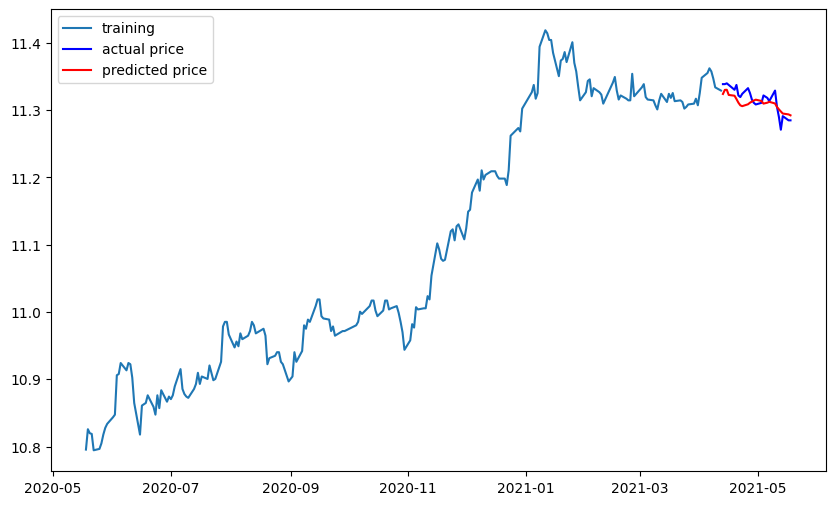

In [85]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = np.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1115050.7120477168
MAE:  889.8750788496039
RMSE:  1055.9596166746703
MAPE: 1.08%


## 회고
음,,분명 배운 거 같은데 배운 거 같지 않은 느낌이 드는,,?   
너무 어려운 거 같다..시계열은  

분명 봤던 코드인데 왜이리 처음 보는 거 마냥 늘 새롭다.  
새로우면 안될 거 같은데 볼때마다 뭔지 몰라서 갈고리 수집가가 된 느낌이다.  

찾아보고 GPT 써보고,, Gemini 써보고 구글링 해보고 
어렵다... 그냥 어렵다..

숫자 찾는 것도 아직까지 어려운 거 같다..
노가다..? 하는 느낌이고..~  

공부만이 살 길 같다. ;(